# Q3 - Using Builtin RNN Classes

In [24]:
import os, sys, time, string, unicodedata
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cpu")
if torch.cuda.is_available: device = torch.device("cuda"); print("Using GPU")

Using GPU


# Download and Preprocess Data

In [3]:
!curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip
!unzip -q -o -d ./data /tmp/trainDevTestTrees_PTB.zip
!rm -f /tmp/trainDevTestTrees_PTB.zip

In [4]:
def normalize_sentence(s):
    replacements = [(" ,", ","), (" .", "."), (" '", "'"), 
                    ("\/", "/"), (" ;", ";"), (" :", ":"),
                    (" %", "%"), (u"æ", "ae"), (u"Æ", "AE"), 
                    (u"œ", "oe"), (u"Œ", "OE"), ("-LRB- ", "("), 
                    (" -RRB-", ")"), ("-LRB-", "("), ("-RRB-", ")"),
                    (" n't", "n't"), ("`` ", '"'), ("``", '"'),
                    ("''", '"'), ("` ", "'"), ("$ ", "$"),
                    (" !", "!"), ("\\", ""), (" ?", "?")]
    for to_replace, replacement in replacements:
        s = s.replace(to_replace, replacement)
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters + ' .,;:\'-#!/"=&$?|_'
    ) # https://stackoverflow.com/a/518232/2809427

def get_corpus(path, eol=' '):
    corpus = ""
    with open(path, 'r') as fp:
        for line in fp.readlines():
            soup = line.split()
            tokens = []
            for chunk in soup[2:]:
                if chunk.endswith(')'):
                    tokens.append(chunk.rstrip(')'))
            corpus += normalize_sentence(" ".join(tokens)) + eol
    return corpus

train_corpus = get_corpus("./data/trees/train.txt")
val_corpus = get_corpus("./data/trees/dev.txt")
test_corpus = get_corpus("./data/trees/test.txt")

In [5]:
chars = list(set(train_corpus))
vocab_size = len(chars)
char_to_idx = { ch:i for i,ch in enumerate(chars) }
idx_to_char = { i:ch for i,ch in enumerate(chars) }
print('Train corpus has {} unique chars.'.format(vocab_size))

Train corpus has 67 unique chars.


In [6]:
class SSTDataset(torch.utils.data.Dataset):
    def __init__(self, corpus, seq_len, vocab_size, device):
        self.corpus = corpus
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.device = device
        self.corpus_len = len(self.corpus)
        self.corpus_tensor = torch.tensor([char_to_idx[c] for c in self.corpus]).to(device)
        self.corpus_ohe = torch.zeros(self.corpus_len, self.vocab_size).to(device)
        for i in range(self.corpus_len):
            self.corpus_ohe[i, self.corpus_tensor[i]] = 1
        
        print('corpus is {} characters long, {} unique chars.'.format(
            self.corpus_len, self.vocab_size))
    
    def __len__(self):
        return len(self.corpus) // seq_len
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        start = idx * self.seq_len
        input = self.corpus_ohe[start:start+self.seq_len]
        target = self.corpus_tensor[start+1:start+self.seq_len+1]
        return input, target

In [7]:
# Load datasets
seq_len = 200
train_dataset = SSTDataset(train_corpus, seq_len, vocab_size, device)
val_dataset = SSTDataset(val_corpus, seq_len, vocab_size, device)
test_dataset = SSTDataset(test_corpus, seq_len, vocab_size, device)

corpus is 858720 characters long, 67 unique chars.
corpus is 111526 characters long, 67 unique chars.
corpus is 222395 characters long, 67 unique chars.


# Model Implementation

In [9]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, arch="vanilla"):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.arch = arch
        
        # Select what architecture to use.
        # Since we don't need to provide hidden_0 (or cell_0) tensors
        # for any of the models, we can use this one class for all 3
        if arch == "vanilla":
            self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        elif arch == "gru":
            self.rnn = nn.GRU(vocab_size, hidden_size, batch_first=True)
        elif arch == "lstm":
            self.rnn = nn.LSTM(vocab_size, hidden_size, batch_first=True)
            
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input):
        hs, h_n = self.rnn(input)
        outputs = self.fc(hs).squeeze()
        outputs = torch.softmax(outputs, axis=-1) # size [batch_size, seq_len, vocab_size]
        return outputs, h_n

In [10]:
batch_size = 8

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                batch_size=len(val_dataset), shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                batch_size=len(test_dataset), shuffle=True, drop_last=True)

## Define Hyperparameters

In [16]:
# hyperparameters
hidden_size = 250 # size of hidden layer
lr = 1e-3
n_epochs = 100
init_patience = 5
arch = "gru"
PATH = "./models/{}-{}".format(arch, time.strftime("%m-%d-%H%M", time.gmtime()))

rnn = RNN(vocab_size, hidden_size, arch).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr=lr)
losses, train_accs, val_accs = np.zeros(n_epochs), np.zeros(n_epochs), np.zeros(n_epochs)
epoch, patience = 0, init_patience

## Train Model

In [17]:
def get_acc(model, data_loader):
    acc, n_chars = 0., 0
    with torch.no_grad(): # Don't save computation tree
        for input_batch, target_batch in data_loader:
            outputs, _ = model(input_batch)
            acc += torch.sum(outputs.argmax(axis=-1) == target_batch)
            n_chars += target_batch.numel()
    return acc / n_chars

while epoch < n_epochs and patience > 0:
    batch_loss = 0
    n_batches = len(train_dataset) // batch_size
    
    # Compute accuracies
    train_accs[epoch] = get_acc(rnn, train_loader)
    val_accs[epoch] = get_acc(rnn, val_loader)
    
    # Perform forward pass and backprop
    for input_batch, target_batch in train_loader:
        rnn.zero_grad()
        outputs, h_n = rnn(input_batch)
        loss = 0
        for t in range(target_batch.size(1)): # seq len
            loss += criterion(torch.log(outputs[:, t]), target_batch[:, t])
        loss /= target_batch.size(1) # seq len
        loss.backward()
        optimizer.step()
        
        batch_loss += loss

    losses[epoch] = batch_loss / n_batches
    print("Epoch {}: Loss {:.6f}, Train Acc {:.2%}, Val Acc {:.2%}"
          .format(epoch, losses[epoch], train_accs[epoch], val_accs[epoch]))    

    # Implements patience: will break if acc doesn't improve for 5 consecutive epochs
    if val_accs[epoch] < val_accs.max(): patience -= 1
    else: patience = init_patience # reset patience if we improve
    epoch += 1
print("************ DONE ************")

Epoch 0: Loss 2.561509, Train Acc 2.07%, Val Acc 2.05%
Epoch 1: Loss 2.124767, Train Acc 35.24%, Val Acc 35.22%
Epoch 2: Loss 1.943786, Train Acc 40.76%, Val Acc 40.75%
Epoch 3: Loss 1.813608, Train Acc 45.13%, Val Acc 45.09%
Epoch 4: Loss 1.715846, Train Acc 48.67%, Val Acc 48.54%
Epoch 5: Loss 1.642568, Train Acc 51.15%, Val Acc 50.81%
Epoch 6: Loss 1.586692, Train Acc 52.86%, Val Acc 52.22%
Epoch 7: Loss 1.542223, Train Acc 54.20%, Val Acc 53.42%
Epoch 8: Loss 1.506464, Train Acc 55.40%, Val Acc 54.29%
Epoch 9: Loss 1.476364, Train Acc 56.11%, Val Acc 54.90%
Epoch 10: Loss 1.451110, Train Acc 57.04%, Val Acc 55.60%
Epoch 11: Loss 1.429590, Train Acc 57.67%, Val Acc 55.86%
Epoch 12: Loss 1.410797, Train Acc 58.25%, Val Acc 56.29%
Epoch 13: Loss 1.393896, Train Acc 58.68%, Val Acc 56.58%
Epoch 14: Loss 1.379291, Train Acc 59.08%, Val Acc 56.77%
Epoch 15: Loss 1.365588, Train Acc 59.66%, Val Acc 57.13%
Epoch 16: Loss 1.353142, Train Acc 60.01%, Val Acc 57.35%
Epoch 17: Loss 1.341774, T

In [32]:
END = np.where(train_accs == 0)[0][0]
print("Model finished within {} epochs.".format(END))

Model finished within 35 epochs.


In [37]:
try: os.mkdir(PATH)
except: print("Directory Exists... Skipping")

Directory Exists... Skipping


In [38]:
rnn.losses = losses[:END]
rnn.train_accs = train_accs[:END]
rnn.val_accs = val_accs[:END]
torch.save(rnn, os.path.join(PATH, "model.torchmodel"))

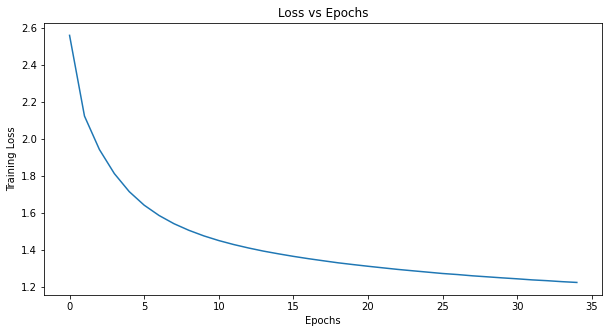

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(rnn.losses)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.savefig(os.path.join(PATH, "loss_curve.png"))

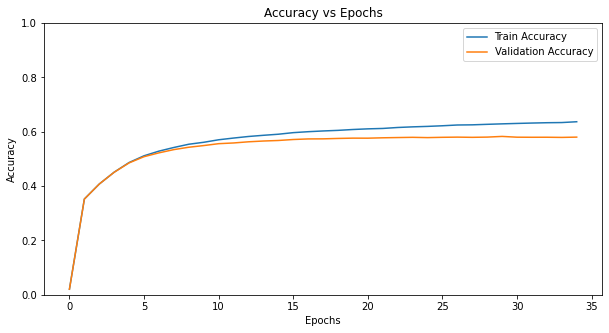

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(rnn.train_accs)
plt.plot(rnn.val_accs)
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.savefig(os.path.join(PATH, "acc_curve.png"))

## Test Accuracy

In [46]:
print("Test accuracy: {:.2%}".format(get_acc(rnn, test_loader)))

Test accuracy: 57.87%


# Generate Sequences

In [45]:
def predict_one(model, s, argmax=False):
    batch_size = 1
    corpus_tensor = torch.tensor([char_to_idx[c] for c in s])
    corpus_ohe = torch.zeros(batch_size, corpus_tensor.size(0), vocab_size).to(device)
    for i in range(corpus_tensor.size(0)):
        corpus_ohe[0, i, corpus_tensor[i]] = 1
    
    with torch.no_grad():
        outputs, _ = model(corpus_ohe)
        last_prob = outputs[-1]
        argmax_idx = last_prob.argmax().item()
        sample_idx = last_prob.multinomial(num_samples=1, replacement=True).item()
        
        if argmax:
            pred_char = idx_to_char[argmax_idx]
        else:
            pred_char = idx_to_char[sample_idx]
    return pred_char

def predict_n_from_seed(n, seed, model):
    output = seed
    for _ in range(n - len(output)):
        c = predict_one(model, output)
        output += c
    return output

predict_n_from_seed(200, '"To be or not to be', rnn)

'"To be or not to be darks a fall picked phonanced and pitched off another and mediocre junk beganed details he was taw look a half-down the bentament with a few of the issible defeatingly, indulgently'